<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" />

# # Project 3 : Web API and NLP - Classification Models and Final Summary

## Overview:

** As part of this project, created 3 notebooks **

1. <a href="01_Data_Gathering.ipynb" Title="Data Gathering">01_Data_Gathering</a> - reads the API and runs in a loop with timer to get 100 submissions at a time. Used gaming section with - boardgames (1400), fallout (1600), rocketleague(1500) and destinythegame (400 rows) to use a total of 4900 rows.
2. <a href="02_NLP.ipynb" Title="NLP">02_NLP</a> - notebook represents EDA and NLP processing
3. <a href="03_Classification_Model.ipynb" Title="Models">03_Classification_Models</a> - Pulls the csv saved to create different classification models and get predictions with scores.

For Classification notebook, we will perform the following:

1. Since this is multi-classification problem, MultinomialNB and SVC models have been chosen as they work best with multi classifier problems and are faster to evaluate. We can additionally evaluate for XGBClassifier from xgboost.
2. Read csv that has been cleaned with NLP techniques and ready to be modeled
3. Define X and y and get the train, test split from X and y
4. Created first model using Naïve Bayes theorem, Multinomial with GridSearchCV Pipeline/CountVectorizer 
5. Create second model using SVM - support vector classifier with GridSearchCV/CountVectorizer and tuned hyper pararmeters.
6. Created third model using Naïve Bayes theorem, Multinomial with GridSearchCV Pipeline/TfidfVectorizer

## Part 1: Imports and Read

In [1]:
#imports
import pandas as pd
import numpy as np

from sklearn.feature_extraction import text

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
#read the csv
reddit_df = pd.read_csv("datasets/redditready.csv")
reddit_df.head()

,subreddit,submission_text,post_word_count,post_char_count,post_length
0,boardgames,do codenames online,3,17,19
1,boardgames,I was reading the comments on a Brothers Murph...,179,733,911
2,boardgames,Welcome to r boardgames s Daily Discussion and...,239,1233,1471
3,boardgames,What are your favourites when you re playing s...,65,285,349
4,boardgames,A giant empty box is 55 with shipping and the ...,135,569,703


In [3]:
#get the current shape
reddit_df.shape

(4091, 5)

## Part 2: Create functions used most commonly

In [4]:
#created functions for repeated tasks
#resources: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
 
# 1. train_test_split function, returns X and y train and test data
def tt_split ():
    
    X = reddit_df['submission_text']
    y = reddit_df['subreddit']

    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.25,
                                                     stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

#2. print accuracy scores in notebook
def print_scores(acc_train_score, acc_test_score):
    print(f'Accuracy score on Train Data: {acc_train_score}')
    print(f'Accuracy score on Test Data: {acc_test_score}')
    
#3. print classification report in a dataframe for each model
def get_clf_report(ytest, ypred):
    
    report = classification_report(ytest, ypred, output_dict=True)
    #creating dataframe
    df = pd.DataFrame(report).transpose()
    #sorting by f1-score
    df = df.sort_values(by=['f1-score'], ascending=False)
    return df

In [5]:
#add own stop words
#setup custom stop words that are not relevant for our context.
my_stop = ['game', 'games', 'board', 'fallout', 'rocket', 'league', 'dont', 'does', 'know', 'new',
          'amp','auto', 'format', 'x200b', 'jpg', 'pjpg', 'https', 've', 'wan', 'na', 'feel', 'feels',
          'played', 'player', 'just', 'think', 'just', 'play', 'got','playing', 'don', 'card', 'people', 
           'players', 'thanks']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop)

In [6]:
#Getting the baseline for y_test
X_train, X_test, y_train, y_test = tt_split()
y_test.value_counts(normalize=True)

RocketLeague    0.346041
Fallout         0.342131
boardgames      0.311828
Name: subreddit, dtype: float64

### Summary:

1. Created common functions above on train_test_split and print our scores
2. Created the base line for y_test 
| Game category  | baseline  |
|---|---|
| Fallout |  0.342131 |
| RocketLeague | 0.346041  |
| boardgames | 0.311828 |


## Part 2: MultinomialNB Classifier with GridSearchCV/Pipeline/CountVectorizer

In [7]:
#calling tt_split function to get test and train data
X_train, X_test, y_train, y_test = tt_split()

In [8]:
#Setup pipeline and params for our GridSearchCV
pipe = Pipeline([('cvec', CountVectorizer(stop_words=stop_words)),
                ('nb', MultinomialNB())
                ])
        
pipe_params = {
               'cvec__max_features': [3_000, 4_000],
               'cvec__min_df': [1, 2],
               'cvec__max_df': [.85, .9, .95],
               'cvec__ngram_range': [(1,1), (1,2)]
                }

#initiate GridSearchCV
gs = GridSearchCV(estimator=pipe, param_grid=pipe_params, cv=5)

In [9]:
# Fit the train data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [10]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

In [11]:
#print our scores, call function
print_scores (gs.score(X_train, y_train), gs.score(X_test, y_test))

Accuracy score on Train Data: 0.8604954367666232
Accuracy score on Test Data: 0.7966764418377321


In [12]:
#Get predictions
y_pred = gs.predict(X_test)

In [13]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
RocketLeague,0.751174,0.903955,0.820513,354.000000
boardgames,0.858621,0.780564,0.817734,319.000000
accuracy,0.796676,0.796676,0.796676,0.796676
macro avg,0.803699,0.795792,0.795702,1023.000000
weighted avg,0.801829,0.796676,0.795131,1023.000000
Fallout,0.801303,0.702857,0.748858,350.000000


In [14]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

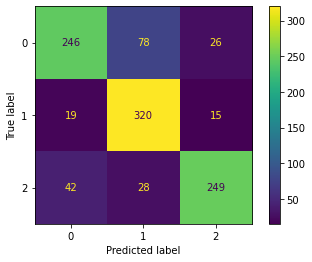

In [15]:
ConfusionMatrixDisplay(cm).plot();

### Summary

**Best hyper parameters for MultinomialNB with CountVectoizer are:**

1. max_df = 0.85
2. max_features = 4000
3. min_df = 1
4. ngram_range = (1, 1)

Even though the model was tuned with hyperparameters and used the best params, the model performed at 79% accuracy score. The model was overfit as the train scores are over than test scores.

- Accuracy score on Train Data: 0.8604954367666232
- Accuracy score on Test Data: 0.7966764418377321


|--|precision|recall|f1-score|support|
|---|---|---|---|---|
|RocketLeague|0.751174|0.903955|0.820513|354.000000|
|boardgames|0.858621|0.780564|0.817734|319.000000|
|Fallout|0.801303|0.702857|0.748858|350.000000|

## Part 3: Support Vector Machine Model with hyper parameters, GridSearchCV/CountVectorizer

In [16]:
# call function to get train_test_split
X_train, X_test, y_train, y_test = tt_split()

In [17]:
#transform using CountVectorizer
cvec = CountVectorizer(stop_words=stop_words, 
                    ngram_range=(1,2),
                    min_df=2
                   )

cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [18]:
# hyper parameter tuning
pipe_params = {
    'C': np.linspace(0.0001, 1, 20),
    'kernel': ['linear', 'rbf'],
    'degree': [2],
    'gamma' : ['scale']
}
# #instantiate support vector classifier
svc = SVC()
# #instantiate GridSearchCV with njobs=8
gs = GridSearchCV(estimator=svc, param_grid = pipe_params, n_jobs=8, verbose=1)

In [19]:
#fit Train data to our model
gs.fit(X_train,y_train) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  1.5min finished


GridSearchCV(estimator=SVC(), n_jobs=8,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00]),
                         'degree': [2], 'gamma': ['scale'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [20]:
#get best params
gs.best_params_

{'C': 0.5263631578947369, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [21]:
#print our scores, call function
print_scores (gs.score(X_train, y_train), gs.score(X_test, y_test))

Accuracy score on Train Data: 0.9722946544980443
Accuracy score on Test Data: 0.7438905180840665


In [22]:
#Get predictions
y_pred = gs.predict(X_test)

In [23]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
RocketLeague,0.681128,0.887006,0.770552,354.000000
boardgames,0.859375,0.689655,0.765217,319.000000
accuracy,0.743891,0.743891,0.743891,0.743891
macro avg,0.760778,0.741744,0.742614,1023.000000
weighted avg,0.757478,0.743891,0.742039,1023.000000
Fallout,0.741830,0.648571,0.692073,350.000000


In [24]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

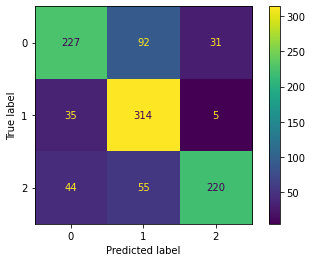

In [25]:
ConfusionMatrixDisplay(cm).plot();

### Summary

** After iterating through hyper parameters and the best params have found to be:
{'C': 0.5263631578947369, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Looking at the train and test scores: 
Accuracy score on Train Data: 0.9722946544980443
Accuracy score on Test Data: 0.7438905180840665
The model is found to be way overfit. Train score was great but test score performed very poorly.

The accuracy score for model is at 74%, the precision only shows 85% for boardgames, 68% for RocketLeague, 74% for Fallout sub reddits.


|---|precision|recall|f1-score|support|
|---|---|---|---|---|
|RocketLeague|0.681128|0.887006|0.770552|354.000000
|boardgames|0.859375|0.689655|0.765217|319.000000
|Fallout|0.741830|0.648571|0.692073|350.000000



### Part 4 : MultinomialNB Classifier with GridSearchCV/Pipeline/TfidfVectorizer

In [26]:
# call function to get train_test_split
X_train, X_test, y_train, y_test = tt_split()

In [27]:
#set the pipeline for tfdif and MiltinomialNB
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#include tdiff vector params
pipe_params = {
    'tvec__max_features':[2_000, 3_000, 4_000],
    'tvec__stop_words':[stop_words],
    'tvec__ngram_range':[(1,2)]
}


In [28]:
#Instantiate GridSearchCV
gs_tvec = GridSearchCV(pipe, param_grid = pipe_params, cv=5)

In [29]:
#Fit with GridSearchCV
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am',
                                                         'among', 'amongst',
                                 

In [30]:
gs_tvec.best_params_

{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'amp',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'auto',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',
            'becoming',
        

In [31]:
#print our scores, call function
print_scores (gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test))

Accuracy score on Train Data: 0.8983050847457628
Accuracy score on Test Data: 0.8064516129032258


In [32]:
#Get predictions
y_pred = gs_tvec.predict(X_test)

In [33]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
boardgames,0.902098,0.808777,0.852893,319.000000
RocketLeague,0.762836,0.881356,0.817824,354.000000
macro avg,0.814124,0.806235,0.807643,1023.000000
accuracy,0.806452,0.806452,0.806452,0.806452
weighted avg,0.811258,0.806452,0.806312,1023.000000
Fallout,0.777439,0.728571,0.752212,350.000000


In [38]:
#creating pdf to check value counts for y_pred from our model
y_df = pd.DataFrame({'xtest' : X_test, 'ypred': y_pred})


In [40]:
#value counts for our prediction
y_df['ypred'].value_counts(normalize=True)

RocketLeague    0.399804
Fallout         0.320626
boardgames      0.279570
Name: ypred, dtype: float64

In [34]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

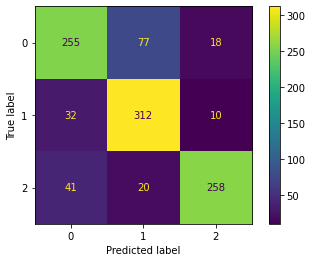

In [35]:
ConfusionMatrixDisplay(cm).plot();

### Summary:

Overall, MultinomialNB with TfidfVectorizer model performed better even though it was sligthly overfit. Ther model produced the scores as following:
- Accuracy score on Train Data: 0.8983050847457628
- Accuracy score on Test Data: 0.8064516129032258

The accuracy score for the model is at 80.64%. 

|---|precision|recall|f1-score|support|
|---|---|---|---|---|
|boardgames|0.902098|0.808777|0.852893|319.00000|
|RocketLeague|0.762836|0.881356|0.817824|354.000000|
|Fallout|0.777439|0.728571|0.752212|350.000000|

When compared to SVM classifier, this model performed with better precision score for boardgames topping at 90%.

******************************************End of Notebooks*****************************************